<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/Latihan_Neural_Network_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jcopdl
!pip install jcopml

In [2]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_missing_value, plot_confusion_matrix, plot_correlation_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Grayscale(),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.5, ), (0.5,))
                                ])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=True, num_workers=2)

In [4]:
label2cat = trainset.classes

In [5]:
class FashionClassifier(nn.Module):
  def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
    super().__init__()
    self.fc = nn.Sequential(
        nn.Flatten(),
        linear_block(input_size, n1, dropout=dropout),
        linear_block(n1, n2, dropout=dropout),
        linear_block(n2, output_size, activation='lsoftmax')
    )

  def forward(self, x):
    return self.fc(x)

In [37]:
config = set_config({
    "input_size": 784,
    "n1": 256,
    "n2": 64,
    "output_size": len(trainset.classes),
    "dropout": 0.4
})
len(trainset.classes), len(trainset), len(testset), len(trainloader), len(testloader), trainset.data

(10, 60000, 10000, 469, 79, tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  

In [43]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=5, plot_every=20, outdir='model')

In [59]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc



Epoch     1
Train_cost  = 0.7198 | Test_cost  = 0.4758 | Train_score = 0.7436 | Test_score = 0.8267 |




Epoch     2
Train_cost  = 0.4831 | Test_cost  = 0.4213 | Train_score = 0.8296 | Test_score = 0.8446 |




Epoch     3
Train_cost  = 0.4373 | Test_cost  = 0.4014 | Train_score = 0.8462 | Test_score = 0.8540 |




Epoch     4
Train_cost  = 0.4138 | Test_cost  = 0.3867 | Train_score = 0.8524 | Test_score = 0.8615 |




Epoch     5
Train_cost  = 0.3942 | Test_cost  = 0.3785 | Train_score = 0.8601 | Test_score = 0.8626 |




Epoch     6
Train_cost  = 0.3775 | Test_cost  = 0.3636 | Train_score = 0.8654 | Test_score = 0.8688 |




Epoch     7
Train_cost  = 0.3740 | Test_cost  = 0.3541 | Train_score = 0.8673 | Test_score = 0.8716 |




Epoch     8
Train_cost  = 0.3611 | Test_cost  = 0.3537 | Train_score = 0.8690 | Test_score = 0.8738 |




Epoch     9
Train_cost  = 0.3569 | Test_cost  = 0.3532 | Train_score = 0.8719 | Test_score = 0.8762 |




Epoch    10
Train_cost  = 0.3472 | Test_cost  = 0.3483 | Train_score = 0.8766 | Test_score = 0.8760 |
==> EarlyStop patience =  1 | Best test_score: 0.8762




Epoch    11
Train_cost  = 0.3406 | Test_cost  = 0.3397 | Train_score = 0.8766 | Test_score = 0.8775 |




Epoch    12
Train_cost  = 0.3355 | Test_cost  = 0.3370 | Train_score = 0.8786 | Test_score = 0.8801 |




Epoch    13
Train_cost  = 0.3320 | Test_cost  = 0.3333 | Train_score = 0.8817 | Test_score = 0.8806 |




Epoch    14
Train_cost  = 0.3272 | Test_cost  = 0.3320 | Train_score = 0.8820 | Test_score = 0.8812 |




Epoch    15
Train_cost  = 0.3191 | Test_cost  = 0.3315 | Train_score = 0.8840 | Test_score = 0.8825 |




Epoch    16
Train_cost  = 0.3163 | Test_cost  = 0.3322 | Train_score = 0.8850 | Test_score = 0.8805 |
==> EarlyStop patience =  1 | Best test_score: 0.8825




Epoch    17
Train_cost  = 0.3133 | Test_cost  = 0.3306 | Train_score = 0.8860 | Test_score = 0.8848 |




Epoch    18
Train_cost  = 0.3094 | Test_cost  = 0.3338 | Train_score = 0.8874 | Test_score = 0.8809 |
==> EarlyStop patience =  1 | Best test_score: 0.8848




Epoch    19
Train_cost  = 0.3054 | Test_cost  = 0.3250 | Train_score = 0.8876 | Test_score = 0.8826 |
==> EarlyStop patience =  2 | Best test_score: 0.8848




Epoch    20
Train_cost  = 0.3051 | Test_cost  = 0.3178 | Train_score = 0.8886 | Test_score = 0.8860 |


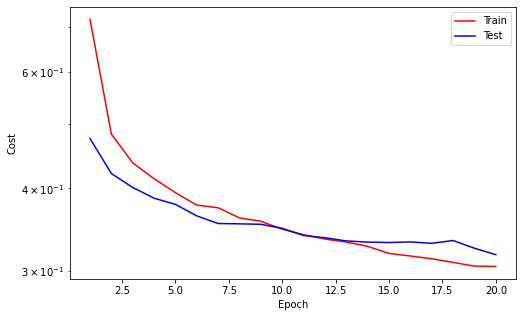

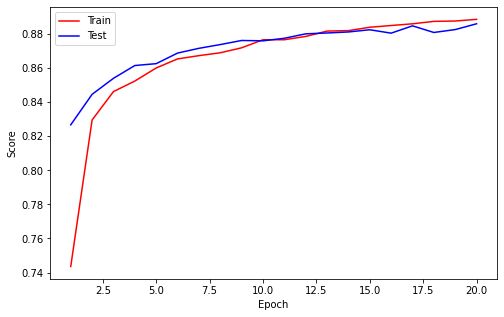



Epoch    21
Train_cost  = 0.3014 | Test_cost  = 0.3384 | Train_score = 0.8900 | Test_score = 0.8818 |
==> EarlyStop patience =  1 | Best test_score: 0.8860




Epoch    22
Train_cost  = 0.2953 | Test_cost  = 0.3217 | Train_score = 0.8928 | Test_score = 0.8836 |
==> EarlyStop patience =  2 | Best test_score: 0.8860




Epoch    23
Train_cost  = 0.2956 | Test_cost  = 0.3492 | Train_score = 0.8911 | Test_score = 0.8738 |
==> EarlyStop patience =  3 | Best test_score: 0.8860




Epoch    24
Train_cost  = 0.2923 | Test_cost  = 0.3322 | Train_score = 0.8930 | Test_score = 0.8832 |
==> EarlyStop patience =  4 | Best test_score: 0.8860




Epoch    25
Train_cost  = 0.2917 | Test_cost  = 0.3198 | Train_score = 0.8935 | Test_score = 0.8900 |




Epoch    26
Train_cost  = 0.2859 | Test_cost  = 0.3251 | Train_score = 0.8964 | Test_score = 0.8854 |
==> EarlyStop patience =  1 | Best test_score: 0.8900




Epoch    27
Train_cost  = 0.2844 | Test_cost  = 0.3170 | Train_score = 0.8952 | Test_score = 0.8860 |
==> EarlyStop patience =  2 | Best test_score: 0.8900




Epoch    28
Train_cost  = 0.2809 | Test_cost  = 0.3239 | Train_score = 0.8967 | Test_score = 0.8892 |
==> EarlyStop patience =  3 | Best test_score: 0.8900




Epoch    29
Train_cost  = 0.2809 | Test_cost  = 0.3225 | Train_score = 0.8966 | Test_score = 0.8879 |
==> EarlyStop patience =  4 | Best test_score: 0.8900




Epoch    30
Train_cost  = 0.2761 | Test_cost  = 0.3256 | Train_score = 0.8992 | Test_score = 0.8884 |
==> EarlyStop patience =  5 | Best test_score: 0.8900
==> Execute Early Stopping at epoch: 30 | Best test_score: 0.8900
==> Best model is saved at model


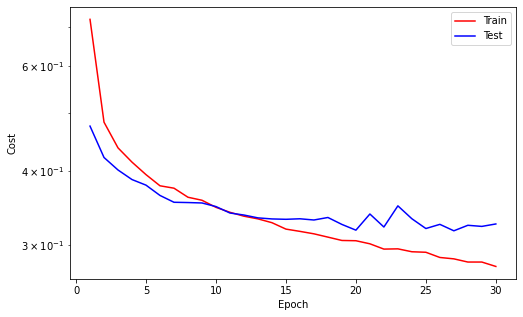

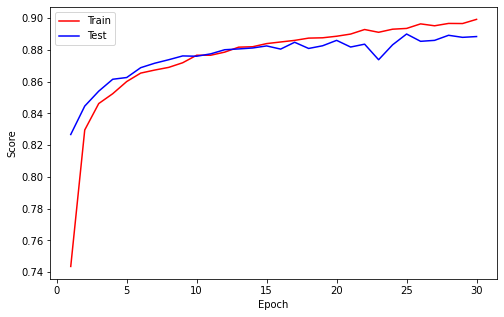

In [60]:
while True:
  train_cost, train_score = loop_fn('train', trainset, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', testset, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

## **# Load Best Model**

In [61]:
weights = torch.load('/content/model/weights_best.pth', map_location="cpu")
config = torch.load('/content/model/configs.pth', map_location='cpu')

model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout)
model.load_state_dict(weights)
model = model.to(device)


In [62]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

# **# Contoh Predict dari data Load**

In [63]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds
[label2cat[pred] for pred in preds]

['Trouser',
 'T-shirt/top',
 'Pullover',
 'Sandal',
 'Coat',
 'Shirt',
 'T-shirt/top',
 'Sneaker',
 'T-shirt/top',
 'T-shirt/top',
 'Dress',
 'Coat',
 'T-shirt/top',
 'Bag',
 'Sandal',
 'Dress',
 'T-shirt/top',
 'Sneaker',
 'Sandal',
 'Dress',
 'Trouser',
 'Shirt',
 'Bag',
 'Ankle boot',
 'Bag',
 'T-shirt/top',
 'Coat',
 'Trouser',
 'Pullover',
 'T-shirt/top',
 'Bag',
 'Shirt',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Dress',
 'Pullover',
 'Sandal',
 'Sandal',
 'Sandal',
 'Shirt',
 'Sandal',
 'Sneaker',
 'Sandal',
 'Pullover',
 'Sandal',
 'Bag',
 'Shirt',
 'Sneaker',
 'Dress',
 'Dress',
 'T-shirt/top',
 'Pullover',
 'Pullover',
 'Pullover',
 'Pullover',
 'Pullover',
 'Bag',
 'T-shirt/top',
 'Sneaker',
 'Trouser',
 'Coat',
 'Bag',
 'Pullover',
 'Pullover',
 'Bag',
 'Pullover',
 'Coat',
 'Pullover',
 'Shirt',
 'Pullover',
 'Ankle boot',
 'Shirt',
 'T-shirt/top',
 'Sneaker',
 'Sandal',
 'Coat',
 'Ankle boot',
 'Bag',
 'T-shirt/top',
 'Trouser',
 'Coat',
 'Sandal',
 'Trouser',
 'Sandal',
 'An

## **# Visualisasi**

In [64]:
import matplotlib.pyplot as plt

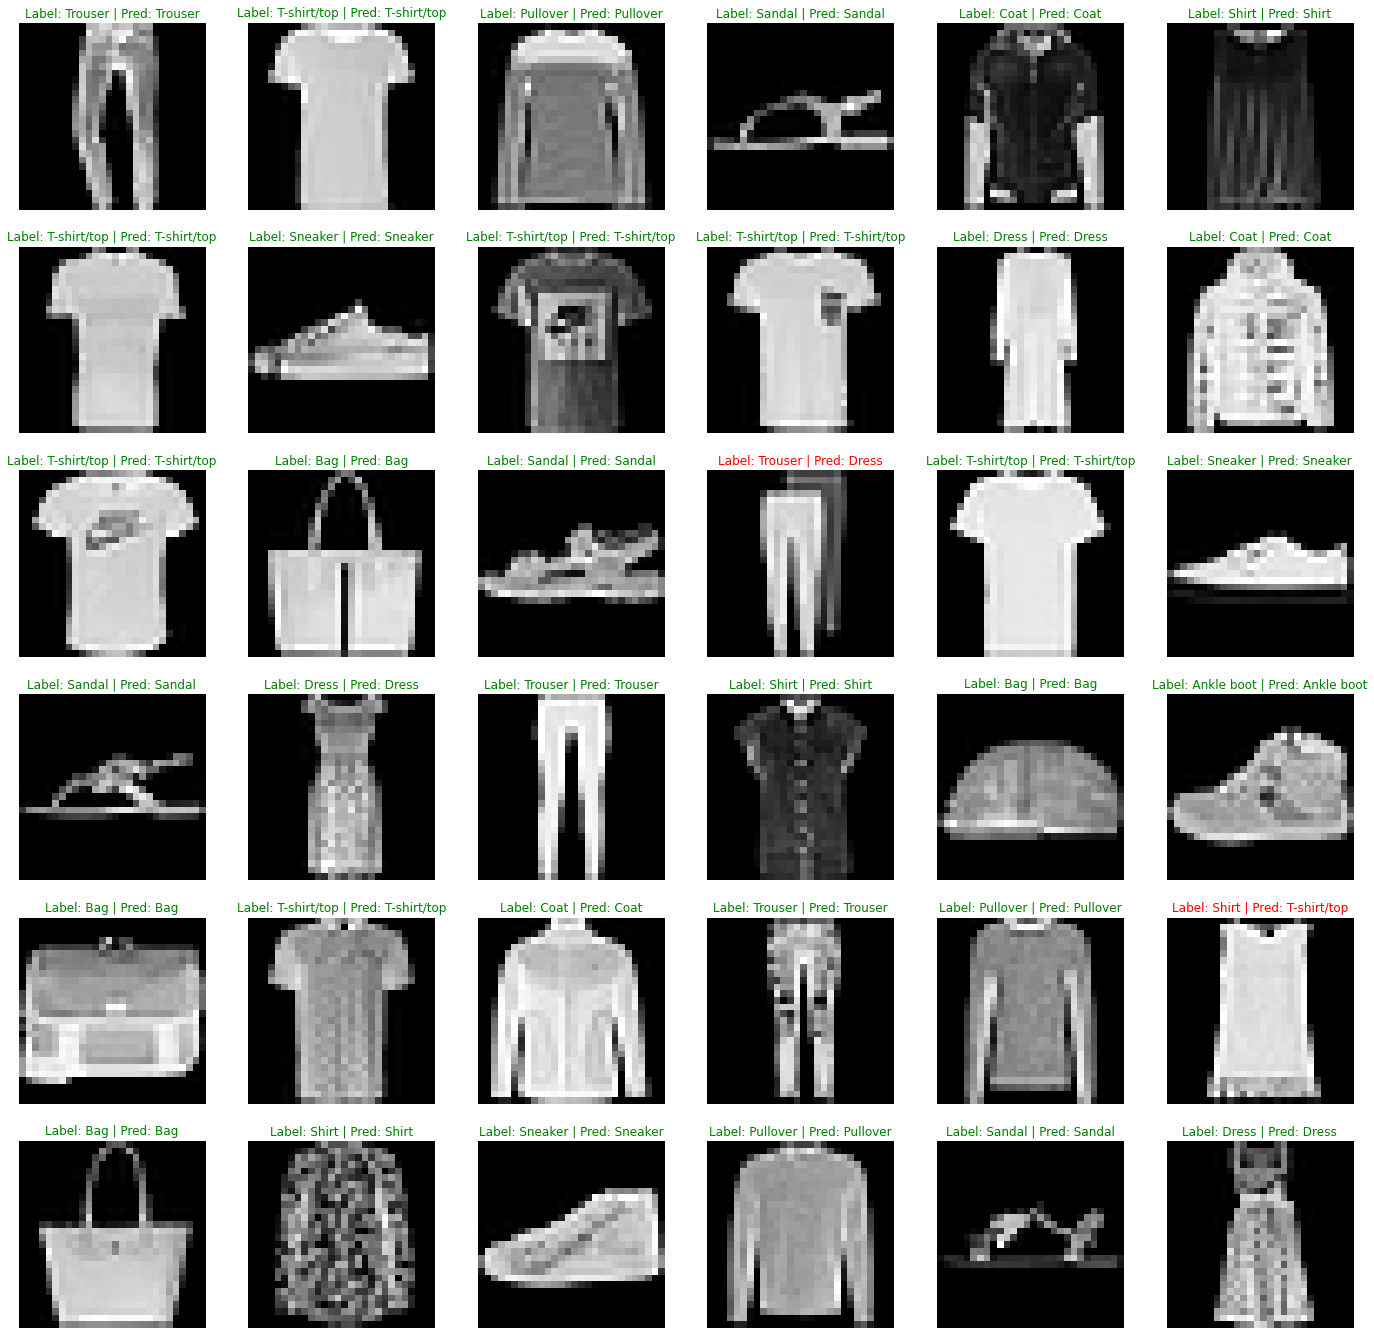

In [65]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.view(28, 28).cpu(), cmap='gray')
  font = {"color":'r'} if label != pred else {"color": 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
  ax.axis("off");